# PREPARATION

In [72]:
import sys
print('Python', sys.version)

import pandas as pd
print('pandas', pd.__version__)

import seaborn as sns
print('seaborn', sns.__version__)

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import __version__
print('sklearn', __version__)

import pickle
print('pickle', pickle.format_version)

from datetime import datetime

import numpy as np
print('numpy', np.__version__)

import matplotlib
import matplotlib.pyplot as plt
print('matplotlib', matplotlib.__version__)

import statsmodels
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
print('statsmodels', statsmodels.__version__)

import math

import utils

Python 3.10.1 (tags/v3.10.1:2cd268a, Dec  6 2021, 19:10:37) [MSC v.1929 64 bit (AMD64)]
pandas 1.3.5
seaborn 0.11.2
sklearn 1.1.1
pickle 4.0
numpy 1.21.4
matplotlib 3.5.1
statsmodels 0.13.2


In [73]:
# Parametri generali
RANDOM_STATE = 0

In [74]:
# Parametri per plot
MARKER_SIZE = 100

COLORMAP_DIVERGENT = 'RdBu'

FIGSIZE = (8, 8)
sns.set_theme(rc={'figure.figsize': FIGSIZE})

# DATASET LOADING

In [75]:
# Carichiamo il datset originale
df = pd.read_csv('###')
df

,Data,Pioggia_Zona_1,Pioggia_Zona_2,Pioggia_Zona_3,Pioggia_Zona_4,Pioggia_Zona_5,Temperatura_Zona_5,Livello_Acqua,Portata_Uscita
0,06/01/2003,NaN,NaN,NaN,NaN,NaN,NaN,30.70,9.6
1,07/01/2003,NaN,NaN,NaN,NaN,NaN,NaN,30.70,9.5
2,08/01/2003,NaN,NaN,NaN,NaN,NaN,NaN,30.67,9.5
3,09/01/2003,NaN,NaN,NaN,NaN,NaN,NaN,30.66,7.2
4,10/01/2003,NaN,NaN,NaN,NaN,NaN,NaN,30.64,6.2
...,...,...,...,...,...,...,...,...,...
6381,26/06/2020,0.0,0.0,0.0,0.0,0.0,22.50,29.85,0.6
6382,27/06/2020,0.0,0.0,0.0,0.0,0.0,23.40,29.84,0.6
6383,28/06/2020,0.0,0.0,0.0,0.0,0.0,21.50,29.83,0.6
6384,29/06/2020,0.0,0.0,0.0,0.0,0.0,23.20,29.82,0.6


In [76]:
# Numero di righe e di colonne
df.shape

(6386, 9)

In [77]:
# Tipologia dei dati contenuti nelle colonne
df.dtypes

Data                   object
Pioggia_Zona_1        float64
Pioggia_Zona_2        float64
Pioggia_Zona_3        float64
Pioggia_Zona_4        float64
Pioggia_Zona_5        float64
Temperatura_Zona_5    float64
Livello_Acqua         float64
Portata_Uscita        float64
dtype: object

In [78]:
# Trasformiamo la colonna 'Data' in formato DateTime
df['Data'] = pd.to_datetime(df['Data'], dayfirst = True)
# Cio' puo' essere utile per estrarre facilmente il mese o l'anno dal formato data

Stampiamo le statistiche descrittive:

In [79]:
# Statistiche descrittive
df.describe()

,Pioggia_Zona_1,Pioggia_Zona_2,Pioggia_Zona_3,Pioggia_Zona_4,Pioggia_Zona_5,Temperatura_Zona_5,Livello_Acqua,Portata_Uscita
count,6026.000000,6026.000000,6026.000000,6026.000000,6026.000000,6025.000000,6386.000000,6386.000000
mean,2.471225,3.340657,2.670063,2.674743,3.129871,14.530141,28.571961,2.784619
std,6.650012,8.903134,7.166643,7.655847,8.025121,6.944029,2.196148,4.098431
min,0.000000,0.000000,0.000000,0.000000,0.000000,-5.350000,22.530000,0.450000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,9.000000,26.930000,0.600000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,14.500000,29.265000,1.500000
75%,0.800000,1.400000,1.200000,0.600000,1.200000,20.100000,30.430000,3.000000
max,80.600000,110.000000,120.200000,113.600000,88.400000,34.000000,31.760000,74.650000


Si può notare come le colonne 'Pioggia_Zona_X', per ogni X in {1,2,3,4,5}, abbiano mediana pari a zero e un percentile 75% molto basso rispetto al loro massimo valore. Questo indica che la maggior parte dei valori di pioggia è pari a zero. Nessuna features e nessuna colonna target sono standardizzate e sono tutte in scale diverse. Può essere utile standardizzare le features ma non le colonne target che vorremmo trattarle in modo isolato e con tecniche specifiche per serie temporali. Sono presenti sessanta valori nulli nelle colonne riguardanti la pioggia e la temperatura, ciò è dovuto all'assenza o malfunzionamento dei sensori di misurazione. Notiamo che sia i valori del Livello che della Portata sono limitati e positivi non nulli. E' importante che sia tutti positivi perchè spesso per risolvere la non stazionarietà in varianza delle serie si applica la funzione logaritmo che richiede un argomento strettamente positivo.

Visualizziamo ora la matrice di correlazione secondo indice di Pearson:

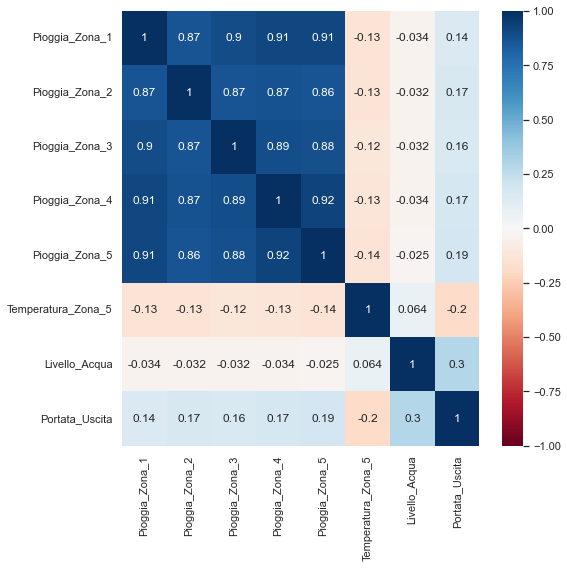

In [80]:
# Calcoliamo la matrice di correlazione
df_corr = df.corr()
# Visualizzazione
sns.heatmap(df_corr, annot=True, cmap=COLORMAP_DIVERGENT, vmin=-1, vmax=1);

Le due colonne target non hanno un'alta correlazione con le colonne features. La Colonna Temperatura_Zona_5 non ha forti correlazioni con le altre features. Le features Pioggia_Zona_X sono fortemente correlate tra loro a causa, probabilmente, della vicinanza tra le zone in cui sono posti i sensori. Una soluzione semplice per risolvere questa collinearità può essere considerare una sola di queste colonne oppure sommandole per ottenere la sola features rigurdante la quantità totale di pioggia caduta. Le features rigurdanti la pioggia non sono fortemente correlate con le due colonne target Livello_Acqua e Portata_Uscita. Si può ragionare sui segni della correlazione: le colonne pioggia hanno correlazione positiva (anche se bassa) con la Portata Uscita. Invece il target Livello_Acqua ha correlazione pari a zero con le colonne Pioggia; si può notare però come il segno sia negativo. 

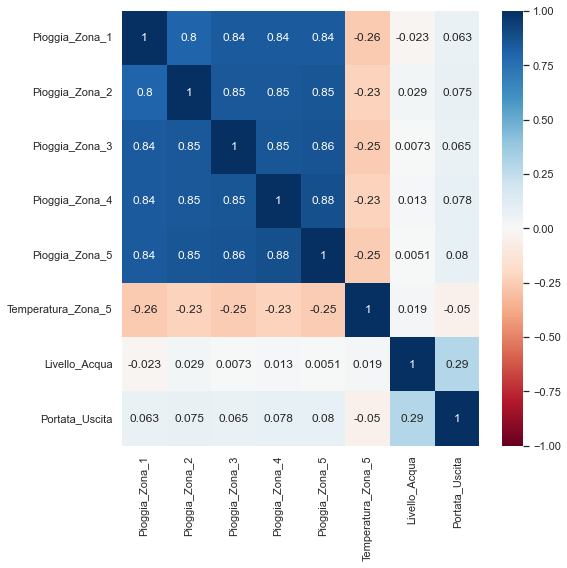

In [81]:
# Spearman correlation
# Calcoliamo la matrice di correlazione con spearman (funzione di correlazione monotona)
df_corr = df.corr(method='spearman')
# Visualizzazione
sns.heatmap(df_corr, annot=True, cmap=COLORMAP_DIVERGENT, vmin=-1, vmax=1);

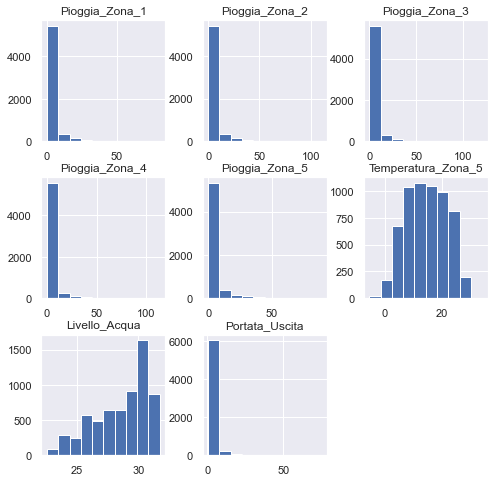

In [82]:
# Istogrammi colonne
colonne_numeriche = ['Pioggia_Zona_1', 'Pioggia_Zona_2', 'Pioggia_Zona_3',
       'Pioggia_Zona_4', 'Pioggia_Zona_5', 'Temperatura_Zona_5',
       'Livello_Acqua', 'Portata_Uscita']
df.hist(colonne_numeriche);

In [83]:
# Definiamo due nuovi variabili, 'Year' e 'Month'
# che saranno utili per raggruppamenti/visualizzazioni
df['Year'] = df['Data'].dt.year 
df['Month'] = df['Data'].dt.month 

In [84]:
# Riordiniamo le colonne per posizionare 'Year' e 'Month' vicino alla colonna 'Data'
cols = ['Data', 'Year', 'Month',
 'Pioggia_Zona_1',
 'Pioggia_Zona_2',
 'Pioggia_Zona_3',
 'Pioggia_Zona_4',
 'Pioggia_Zona_5',
 'Temperatura_Zona_5',
 'Livello_Acqua',
 'Portata_Uscita']
df = df[cols]

# Visualizziamo il nuovo dataset
df.head()

,Data,Year,Month,Pioggia_Zona_1,Pioggia_Zona_2,Pioggia_Zona_3,Pioggia_Zona_4,Pioggia_Zona_5,Temperatura_Zona_5,Livello_Acqua,Portata_Uscita
0,2003-01-06,2003,1,NaN,NaN,NaN,NaN,NaN,NaN,30.70,9.6
1,2003-01-07,2003,1,NaN,NaN,NaN,NaN,NaN,NaN,30.70,9.5
2,2003-01-08,2003,1,NaN,NaN,NaN,NaN,NaN,NaN,30.67,9.5
3,2003-01-09,2003,1,NaN,NaN,NaN,NaN,NaN,NaN,30.66,7.2
4,2003-01-10,2003,1,NaN,NaN,NaN,NaN,NaN,NaN,30.64,6.2


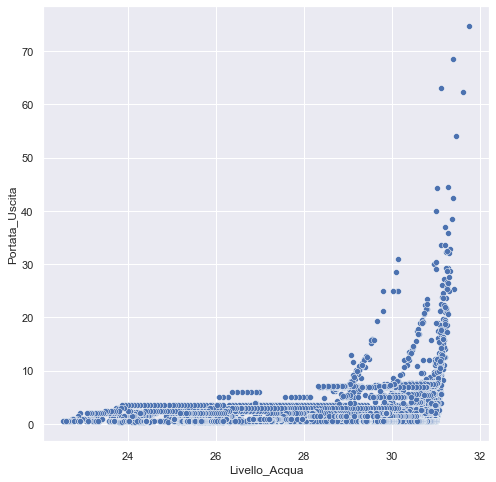

In [85]:
# Scatterplot attributi
sns.scatterplot(x='Livello_Acqua', y='Portata_Uscita', data=df);

In [86]:
# Scatterplot attributi
#sns.scatterplot(x='Pioggia_Zona_5', y='Portata_Uscita', data=df);

Adesso ci concentriamo su uno studio prelimiare delle colonne target e degli attributi

# Visualizzazioni Livello dell'Acqua

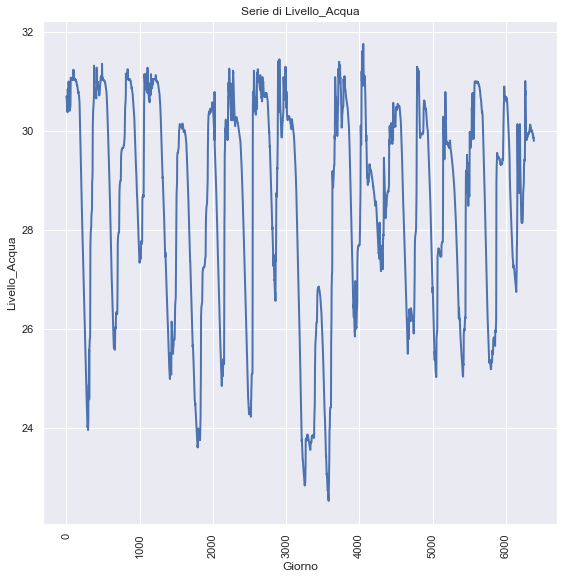

In [87]:
# La funzione plot_series permette di visualizzare, dato un dataset, il plot della la colonna indicata
plot_livello = utils.print_plot(df,'Livello_Acqua')
plot_livello.plot_series()

La serie si sviluppa in range limitato. Sembra avere un comportamento periodico ma per comprenderlo servono altri studi.

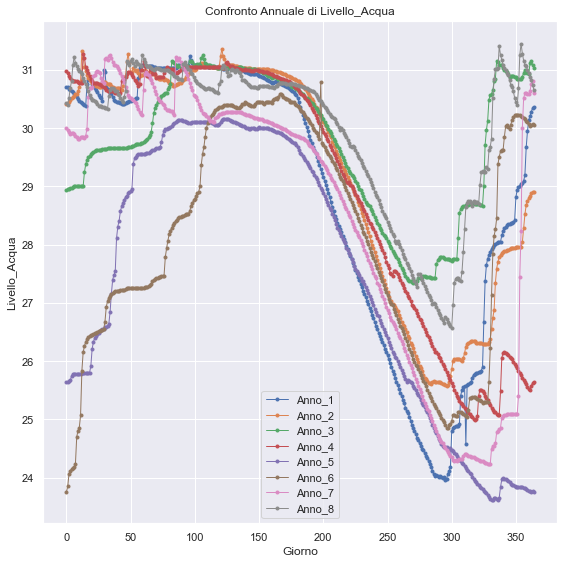

In [88]:
# plot_years_serie permette di visualizzare le serie anno per anno
# Il parametro della funzione è il numero di anni che si vuole visualizzare
plot_livello.plot_years_serie(8)

Si può notare che il valore del Livello dell'Acqua descresce dopo il centocinquantesimo girno dell'anno fino al trecentesimo giorno per poi ricrescere. Le discese sono molto simili e quindi suggeriscono un comportamento simile in quei mesi. Le risalite dopo il trecentesimo giorno sono però molto diverse tra loto, così come lo sono i primi centocinquanta giorni. Quindi non è presente una stagionalità/periodicità così evidente. 

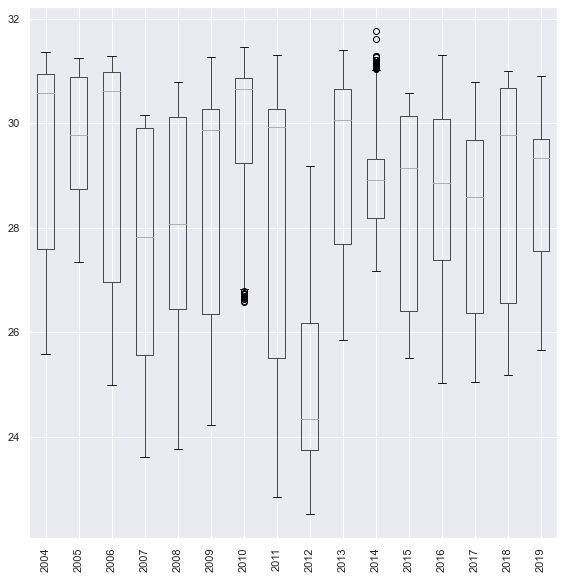

In [89]:
# boxplot_annuali permette di visualizzare i boxplot per ogni anno nel range indicato come input
plot_livello.boxplot_annuali(2004, 2019)

La media anno per anno varia, anche di molto. Questo suggerisce una non stazionarietà in media della serie. Ma anche la varianza varia poichè i baffi del boxplot differiscono al variare degli anni e ciò implica anche una non stazionarietà in varianza. 

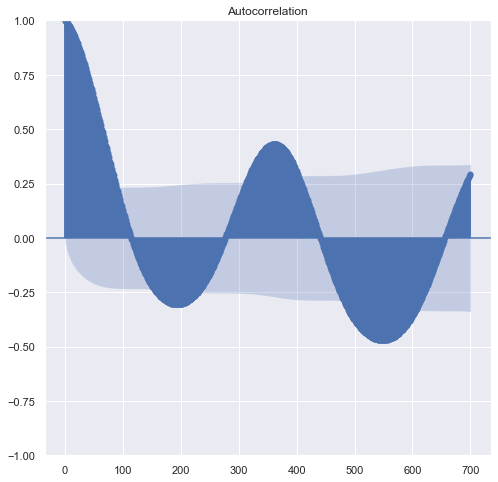

In [90]:
# ACF
plot_acf(df.Livello_Acqua, lags = 700)
plt.show()

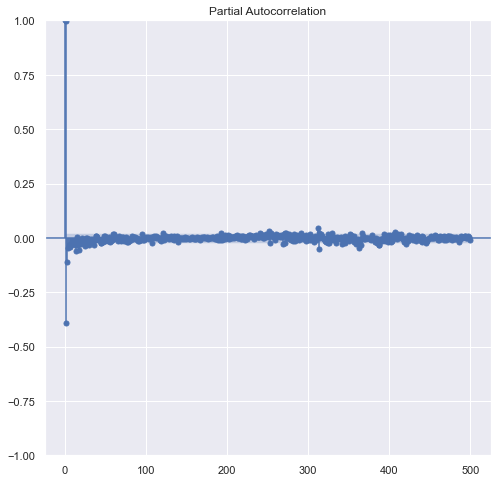

In [91]:
# Pacf
plot_pacf(df.Livello_Acqua, lags = 500, method = 'ywm')
plt.show()

Al momento non si eriesce a individuare un pattern nei grafici ACF e PACF riconducibile facilmente a un modello Sarima. Serve un lavoro di studio più approfondito che sarà svolto nel Notebook Training.

# Visualizzazioni Portata Uscita

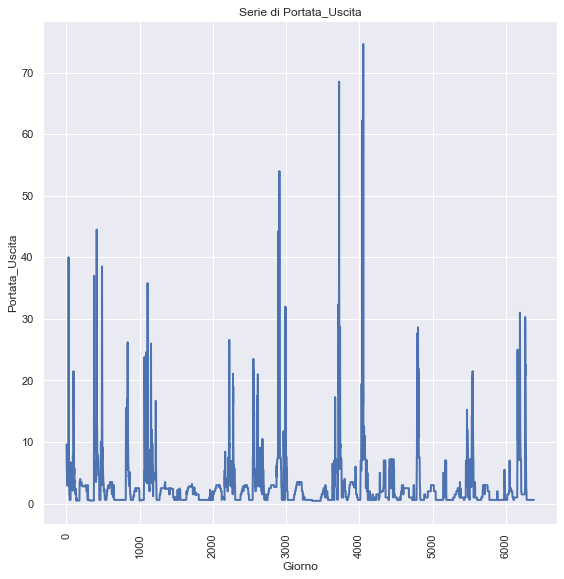

In [92]:
# Plot serie portata
plot_portata = utils.print_plot(df,'Portata_Uscita')
plot_portata.plot_series()

La serie rigurdante la Portata Uscita ha un comportamento poco regolare, infatti assume spesso valori bassi e sono in alcuni giorni sono presenti dei picchi molto alti. 

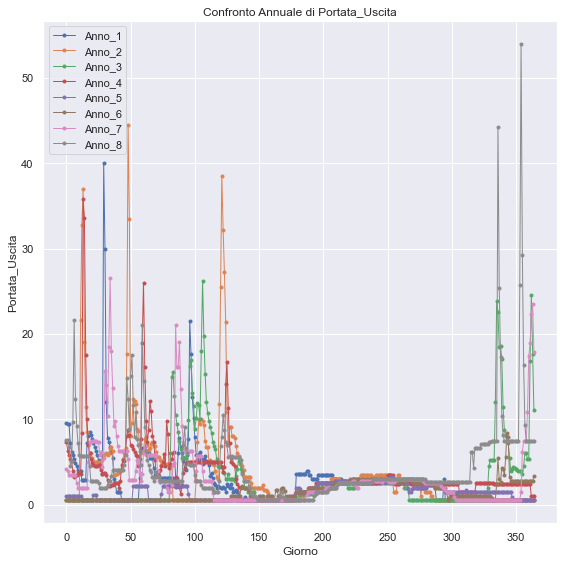

In [93]:
# Plot portata per anno
plot_portata.plot_years_serie(8)

I picchi hanno una cadenza simile ma non sembra regolare.

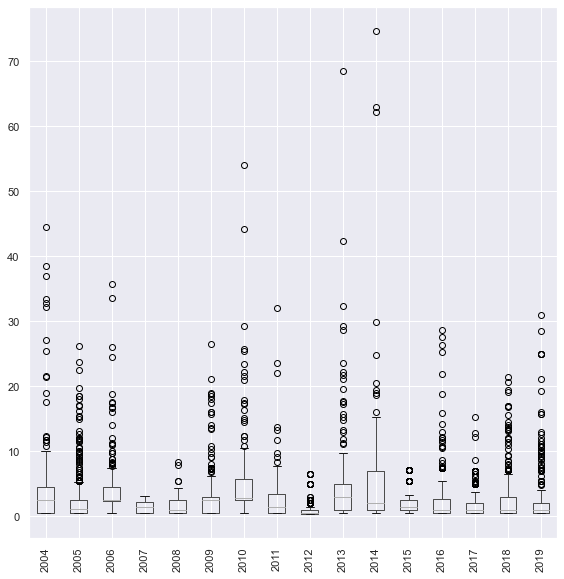

In [94]:
# Boxplot
plot_portata.boxplot_annuali(2004, 2019)

I picchi corrispondono agli outliers in ogni anno. Qui tutte le medie sono molto basse ma le varianze sono molto differenti, ciò suggerisce una non stazionarietà in varianza. 

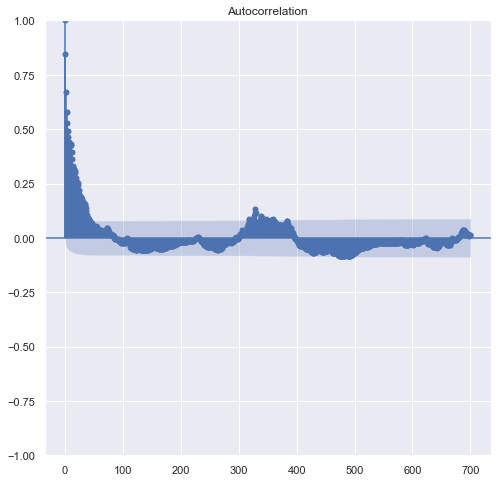

In [95]:
# Acf
plot_acf(df.Portata_Uscita, lags = 700)
plt.show()

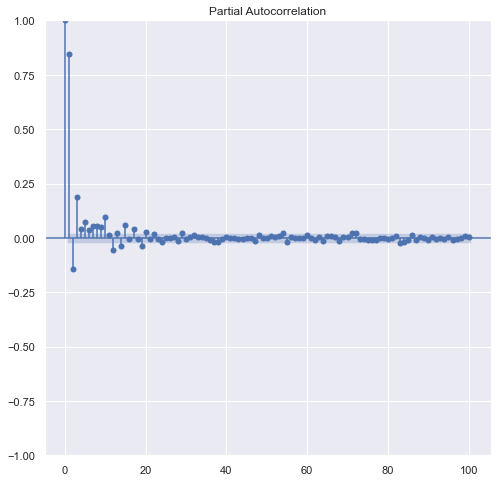

In [96]:
# Pacf
plot_pacf(df.Portata_Uscita, lags = 100, method = 'ywm')
plt.show()

Lo studio dei grafici ACF e PACF viene rimandato al Notebook di Training.

# Visualizzazioni Attributi

In [97]:
# Eliminiamo tutti i valori Nan degli attributi perchè non utilizzabili come valori nei metodi Sarima o Reti Neurali o Regressione
df = df.dropna()
df.head()

,Data,Year,Month,Pioggia_Zona_1,Pioggia_Zona_2,Pioggia_Zona_3,Pioggia_Zona_4,Pioggia_Zona_5,Temperatura_Zona_5,Livello_Acqua,Portata_Uscita
361,2004-01-02,2004,1,0.0,0.0,0.0,0.0,0.0,6.50,30.21,0.5
362,2004-01-03,2004,1,0.0,0.0,0.0,0.0,0.0,4.45,30.28,0.5
363,2004-01-04,2004,1,0.0,0.0,0.0,0.0,0.0,2.00,30.35,0.5
364,2004-01-05,2004,1,0.2,0.0,0.0,0.0,0.0,0.90,30.37,0.5
365,2004-01-06,2004,1,0.0,0.0,0.0,0.0,0.0,2.25,30.42,0.5


In [98]:
# Creiamo attributo Pioggia_Totale dato la somma di tutta la pioggia caduta nelle varie zone
colonne_sum = ['Pioggia_Zona_1','Pioggia_Zona_2','Pioggia_Zona_3','Pioggia_Zona_4','Pioggia_Zona_5']
df = df.assign(Pioggia_Totale=df.loc[:,colonne_sum].sum(axis=1))

In [99]:
# Visualizziamo il dataset
df.head()

,Data,Year,Month,Pioggia_Zona_1,Pioggia_Zona_2,Pioggia_Zona_3,Pioggia_Zona_4,Pioggia_Zona_5,Temperatura_Zona_5,Livello_Acqua,Portata_Uscita,Pioggia_Totale
361,2004-01-02,2004,1,0.0,0.0,0.0,0.0,0.0,6.50,30.21,0.5,0.0
362,2004-01-03,2004,1,0.0,0.0,0.0,0.0,0.0,4.45,30.28,0.5,0.0
363,2004-01-04,2004,1,0.0,0.0,0.0,0.0,0.0,2.00,30.35,0.5,0.0
364,2004-01-05,2004,1,0.2,0.0,0.0,0.0,0.0,0.90,30.37,0.5,0.2
365,2004-01-06,2004,1,0.0,0.0,0.0,0.0,0.0,2.25,30.42,0.5,0.0


## Pioggia totale

In [100]:
# Statistiche descrittive della nuova variabile
df['Pioggia_Totale'].describe()

count    6025.000000
mean       14.288863
std        36.620023
min         0.000000
25%         0.000000
50%         0.200000
75%         7.000000
max       425.600000
Name: Pioggia_Totale, dtype: float64

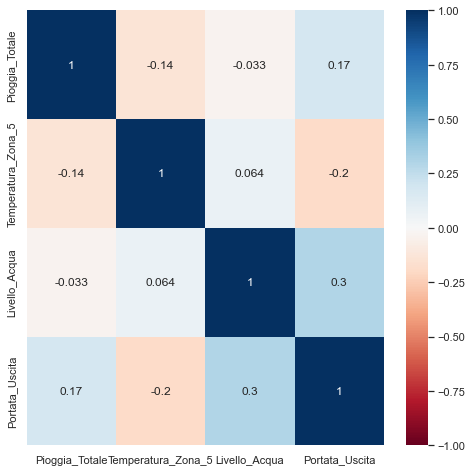

In [101]:
# Vediamo se esistono correlazioni tra il nuovo attributo e le altre colonne
df_corr_pioggia_totale = df[['Pioggia_Totale','Temperatura_Zona_5','Livello_Acqua','Portata_Uscita']].corr()
sns.heatmap(df_corr_pioggia_totale, annot=True, cmap=COLORMAP_DIVERGENT, vmin=-1, vmax=1);

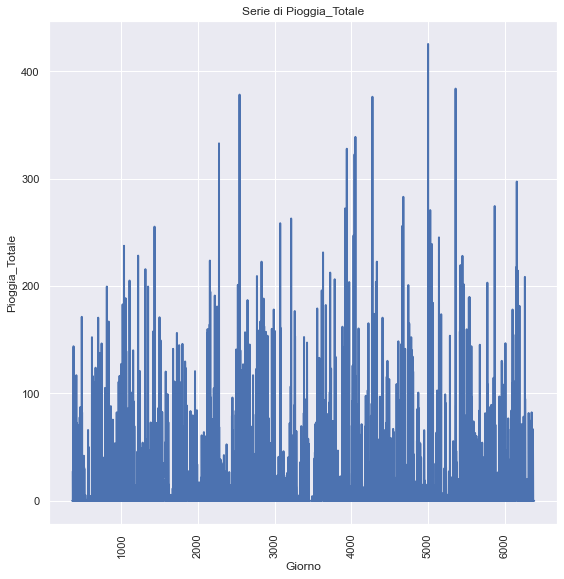

In [102]:
# Plot serie pioggia totale
utils.print_plot(df,'Pioggia_Totale').plot_series()

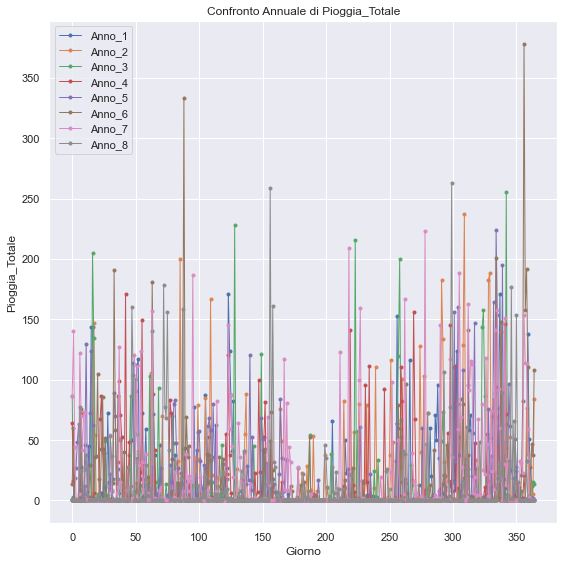

In [103]:
# Plot pioggia per anno
utils.print_plot(df,'Pioggia_Totale').plot_years_serie(8)

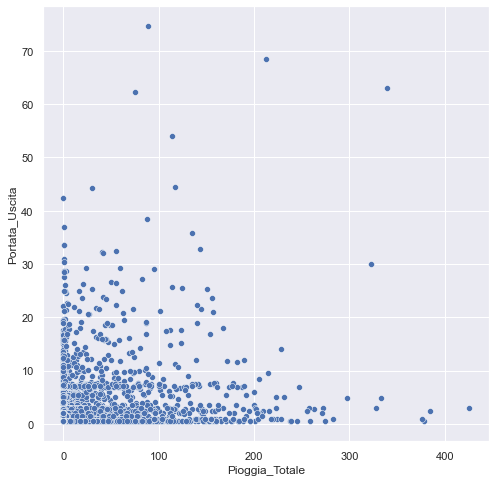

In [104]:
# Scatterplot attributi
sns.scatterplot(x='Pioggia_Totale', y='Portata_Uscita', data=df);

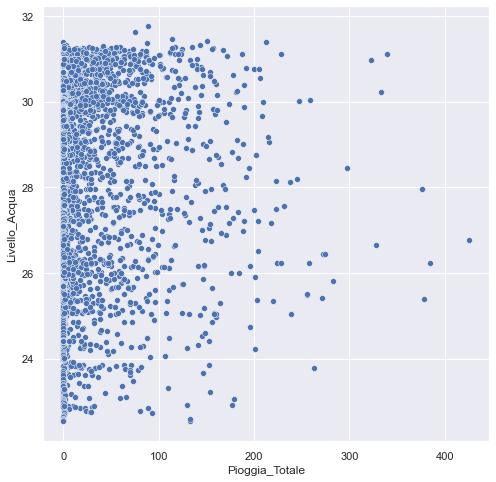

In [105]:
# Scatterplot attributi
sns.scatterplot(x='Pioggia_Totale', y='Livello_Acqua', data=df);

## Temperatura zona 5

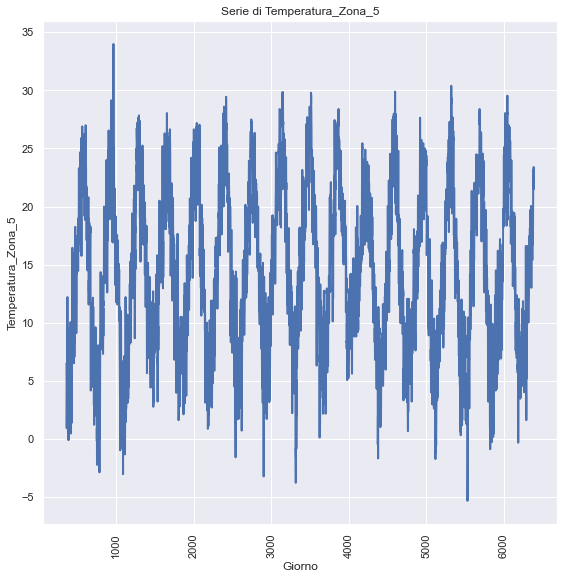

In [106]:
# Plot serie temperatura
utils.print_plot(df,'Temperatura_Zona_5').plot_series()

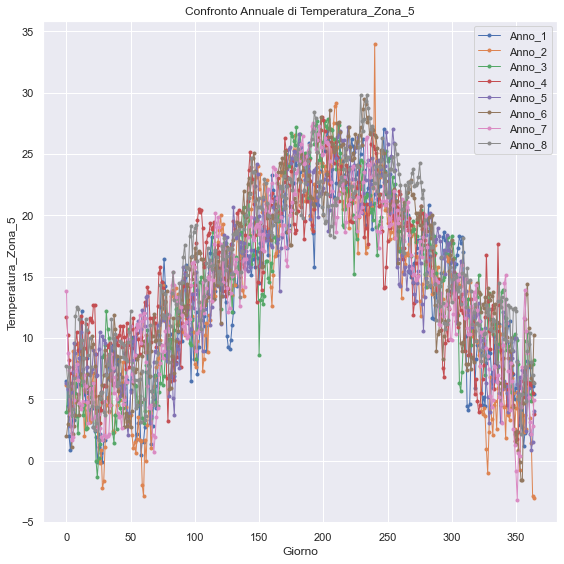

In [107]:
# Plot temperatura per anno
utils.print_plot(df,'Temperatura_Zona_5').plot_years_serie(8)

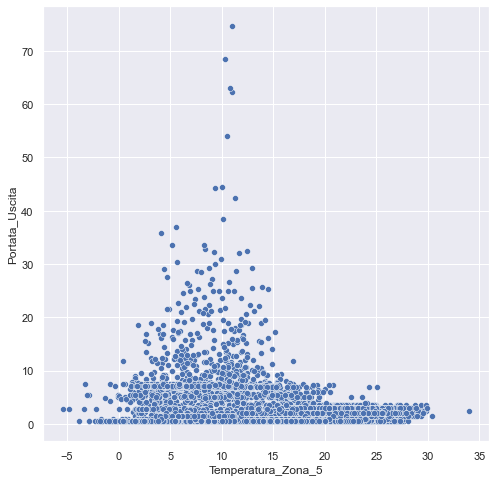

In [108]:
# Scatterplot attributi
sns.scatterplot(x='Temperatura_Zona_5', y='Portata_Uscita', data=df);

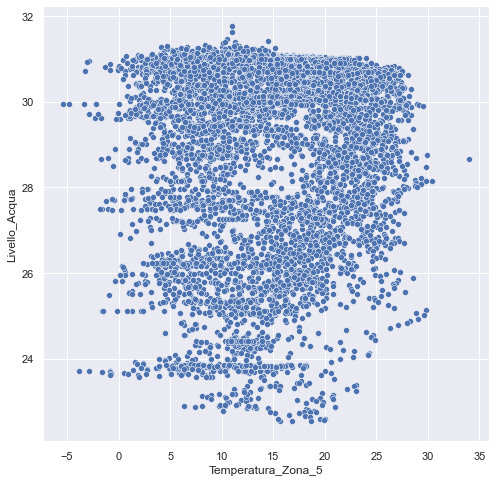

In [109]:
# Scatterplot attributi
sns.scatterplot(x='Temperatura_Zona_5', y='Livello_Acqua', data=df);

# DATASET PREPARATION

## Selezione Features

In [110]:
# Selezioniamo solo la colonna Pioggia Totale a causa dell'alta correlazione tra le colonne pioggia
features = ['Data','Year','Pioggia_Totale', 'Temperatura_Zona_5','Livello_Acqua','Portata_Uscita']
df = df[features]
df.reset_index(drop=True, inplace=True)
df

,Data,Year,Pioggia_Totale,Temperatura_Zona_5,Livello_Acqua,Portata_Uscita
0,2004-01-02,2004,0.0,6.50,30.21,0.5
1,2004-01-03,2004,0.0,4.45,30.28,0.5
2,2004-01-04,2004,0.0,2.00,30.35,0.5
3,2004-01-05,2004,0.2,0.90,30.37,0.5
4,2004-01-06,2004,0.0,2.25,30.42,0.5
...,...,...,...,...,...,...
6020,2020-06-26,2020,0.0,22.50,29.85,0.6
6021,2020-06-27,2020,0.0,23.40,29.84,0.6
6022,2020-06-28,2020,0.0,21.50,29.83,0.6
6023,2020-06-29,2020,0.0,23.20,29.82,0.6


In [111]:
# Aggiungiamo sinusoidi per dataset modelli ARIMA
num_sinusoidi = 2
omega = np.outer(range(1,len(df)+1), range(1,num_sinusoidi+1)) * 2 * math.pi / (365.25)
cc = np.cos(omega)
ss = np.sin(omega)

for i in range(num_sinusoidi):
    df['cc_'+str(i+1)] = cc[:, i]
    df['ss_'+str(i+1)] = ss[:, i]

df.head()

,Data,Year,Pioggia_Totale,Temperatura_Zona_5,Livello_Acqua,Portata_Uscita,cc_1,ss_1,cc_2,ss_2
0,2004-01-02,2004,0.0,6.50,30.21,0.5,0.999852,0.017202,0.999408,0.034398
1,2004-01-03,2004,0.0,4.45,30.28,0.5,0.999408,0.034398,0.997634,0.068755
2,2004-01-04,2004,0.0,2.00,30.35,0.5,0.998669,0.051584,0.994678,0.103031
3,2004-01-05,2004,0.2,0.90,30.37,0.5,0.997634,0.068755,0.990545,0.137185
4,2004-01-06,2004,0.0,2.25,30.42,0.5,0.996303,0.085906,0.985240,0.171177


## Train-test split

In [112]:
# Dividiamo tra train e test ma i dati non devono essere mescolati
# Deve essere mantenuto l'ordine in quanto serie storiche
df_train, df_test = train_test_split(
    df,
    train_size=0.8,
    shuffle=False,
    random_state=RANDOM_STATE
)

In [113]:
# Dimensioni del train e del test
print('Dimensioni del train:',df_train.shape)
print('Dimensioni del test:',df_test.shape)

Dimensioni del train: (4820, 10)
Dimensioni del test: (1205, 10)


In [114]:
# colect_windows e' una funzione che lagga indietro la colonna indicata di 7 giorni
# lagga in avanti le altre colonne indicate del numero indicato 
# inoltre elimina le righe con valori nulli che vengono generate con il lag
df_train_portata = utils.collect_windows(df_train,'Portata_Uscita', 0)
df_test_portata = utils.collect_windows(df_test,'Portata_Uscita', 0)

In [115]:
df_train_portata.shape

(4813, 10)

In [116]:
# Stessa funzione applicata a livello
df_train_livello = utils.collect_windows(df_train,'Livello_Acqua', 0)
df_test_livello = utils.collect_windows(df_test,'Livello_Acqua', 0)

In [117]:
# Creiamo nuovo dataset train per reti neurali
df_train_reti = df_train_portata.copy()
df_train_reti['Livello_Acqua'] = df_train_livello['Livello_Acqua']

In [118]:
# Selezione colonne utili
df_train_reti = df_train_reti[['Data','Year','Pioggia_Totale','Temperatura_Zona_5','Livello_Acqua','Portata_Uscita']]
df_train_reti

,Data,Year,Pioggia_Totale,Temperatura_Zona_5,Livello_Acqua,Portata_Uscita
0,2004-01-02,2004,0.0,6.50,30.49,0.5
1,2004-01-03,2004,0.0,4.45,30.52,0.5
2,2004-01-04,2004,0.0,2.00,30.53,0.5
3,2004-01-05,2004,0.2,0.90,30.55,0.5
4,2004-01-06,2004,0.0,2.25,30.58,0.5
...,...,...,...,...,...,...
4808,2017-03-02,2017,0.0,9.30,30.78,7.0
4809,2017-03-03,2017,73.2,11.25,30.77,7.0
4810,2017-03-04,2017,79.6,8.45,30.70,7.0
4811,2017-03-05,2017,173.8,6.70,30.62,7.0


In [119]:
# Creiamo nuovo dataset test per reti neurali
df_test_reti = df_test_portata.copy()
df_test_reti['Livello_Acqua'] = df_test_livello['Livello_Acqua']

In [120]:
# Selezione colonne utili
df_test_reti = df_test_reti[['Data','Year','Pioggia_Totale','Temperatura_Zona_5','Livello_Acqua','Portata_Uscita']]
df_test_reti

,Data,Year,Pioggia_Totale,Temperatura_Zona_5,Livello_Acqua,Portata_Uscita
4820,2017-03-14,2017,0.0,12.80,29.75,0.6
4821,2017-03-15,2017,0.0,11.80,29.74,0.6
4822,2017-03-16,2017,0.0,12.70,29.74,0.6
4823,2017-03-17,2017,0.0,10.70,29.75,0.6
4824,2017-03-18,2017,0.0,12.00,29.76,0.6
...,...,...,...,...,...,...
6013,2020-06-19,2020,0.0,18.80,29.85,0.6
6014,2020-06-20,2020,0.0,20.00,29.84,0.6
6015,2020-06-21,2020,0.0,21.95,29.83,0.6
6016,2020-06-22,2020,0.0,23.05,29.82,0.6


## Preprocessing per Features

Una strategia potrebbe essere standardizzare le colonne che si vuole utilizzare come attributi. Non sappiamo a priori se convenga standardizzare oppure no, quindi salviamo sia il dataset con le features standardizzate sia quello con le features originali e poi valuteremo le performance dei vari modelli. 

In [121]:
def dataset_normalizzazione(target):
    # Normalizzazione dataset Portata
    scaler = StandardScaler()
    # Normalizzo attributi ma non la colonna target che sarà trattata separatamente e con specifiche tecniche per le serie temporali
    numerical_features = ['Pioggia_Totale', 'Temperatura_Zona_5']
    if target == 'Portata_Uscita':
        
        numerical_features.append('Livello_Acqua')
        
        df_originale_train = df_train_portata
        df_originale_test = df_test_portata
        
    else:
        
        numerical_features.append('Portata_Uscita')
        
        df_originale_train = df_train_livello
        df_originale_test = df_test_livello

    # Modifico dataset
    df_train_prep = pd.DataFrame(
    scaler.fit_transform(df_originale_train[numerical_features]),
    columns=numerical_features,
    index=df_originale_train.index
    )
# Poi al train dobbiamo aggiungere la Data, le due colonne target e le sinusoidi
    df_train_prep[target] = df_originale_train[target]
    df_train_prep['Data'] = df_originale_train['Data']
    df_train_prep['Year'] = df_originale_train['Year']
    df_train_prep['cc_1'] = df_originale_train['cc_1']
    df_train_prep['cc_2'] = df_originale_train['cc_2']
    df_train_prep['ss_1'] = df_originale_train['ss_1']
    df_train_prep['ss_2'] = df_originale_train['ss_2']

# Applichiamo la Standardizzazione al test set
    df_test_prep = pd.DataFrame(
    scaler.transform(df_originale_test[numerical_features]),
    columns=numerical_features,
    index=df_originale_test.index
    )

# Aggiungiamo la colonna Data, le colonne target e le sinusoidi
    df_test_prep[target] = df_originale_test[target]
    df_test_prep['Data'] = df_originale_test['Data']
    df_test_prep['Year'] = df_originale_test['Year']
    df_test_prep['cc_1'] = df_originale_test['cc_1']
    df_test_prep['cc_2'] = df_originale_test['cc_2']
    df_test_prep['ss_1'] = df_originale_test['ss_1']
    df_test_prep['ss_2'] = df_originale_test['ss_2']

    return scaler, df_train_prep, df_test_prep
    

In [122]:
scaler_portata, df_train_prep_portata, df_test_prep_portata = dataset_normalizzazione('Portata_Uscita')
# Mostriamo l'effetto della Standardizzazione
df_train_prep_portata.describe()

,Pioggia_Totale,Temperatura_Zona_5,Livello_Acqua,Portata_Uscita,Year,cc_1,cc_2,ss_1,ss_2
count,4.813000e+03,4.813000e+03,4.813000e+03,4813.000000,4813.000000,4813.000000,4813.000000,4813.000000,4813.000000
mean,-2.657338e-17,4.428897e-16,-9.684522e-16,2.882331,2010.095782,0.010781,0.004614,0.006842,0.009808
std,1.000104e+00,1.000104e+00,1.000104e+00,4.218207,3.803541,0.708728,0.706086,0.705514,0.708190
min,-3.912472e-01,-2.650592e+00,-2.624006e+00,0.450000,2004.000000,-0.999998,-0.999998,-0.999999,-0.999999
25%,-3.912472e-01,-7.968250e-01,-7.506233e-01,0.600000,2007.000000,-0.698310,-0.698310,-0.699079,-0.699079
50%,-3.857869e-01,3.829102e-03,2.891698e-01,2.000000,2010.000000,0.022576,0.009676,0.021501,0.021501
75%,-2.001366e-01,8.044832e-01,8.507458e-01,3.000000,2013.000000,0.721031,0.709005,0.708246,0.718792
max,1.122828e+01,2.802512e+00,1.425484e+00,74.650000,2017.000000,1.000000,1.000000,0.999999,0.999999


In [123]:
scaler_livello, df_train_prep_livello, df_test_prep_livello = dataset_normalizzazione('Livello_Acqua')
# Mostriamo l'effetto della Standardizzazione
df_train_prep_livello.describe()

,Pioggia_Totale,Temperatura_Zona_5,Portata_Uscita,Livello_Acqua,Year,cc_1,cc_2,ss_1,ss_2
count,4.813000e+03,4.813000e+03,4.813000e+03,4813.000000,4813.000000,4813.000000,4813.000000,4813.000000,4813.000000
mean,-2.657338e-17,4.428897e-16,2.066819e-17,28.511394,2010.095782,0.010781,0.004614,0.006842,0.009808
std,1.000104e+00,1.000104e+00,1.000104e+00,2.279978,3.803541,0.708728,0.706086,0.705514,0.708190
min,-3.912472e-01,-2.650592e+00,-5.747118e-01,22.530000,2004.000000,-0.999998,-0.999998,-0.999999,-0.999999
25%,-3.912472e-01,-7.968250e-01,-5.391315e-01,26.800000,2007.000000,-0.698310,-0.698310,-0.699079,-0.699079
50%,-3.857869e-01,3.829102e-03,-2.070485e-01,29.170000,2010.000000,0.022576,0.009676,0.021501,0.021501
75%,-2.001366e-01,8.044832e-01,3.015370e-02,30.450000,2013.000000,0.721031,0.709005,0.708246,0.718792
max,1.122828e+01,2.802512e+00,1.702569e+01,31.760000,2017.000000,1.000000,1.000000,0.999999,0.999999


In [124]:
# Nuovo dataset train per le reti ma con attributi normalizzati
df_train_prep_reti = df_train_prep_portata.copy()
df_train_prep_reti['Livello_Acqua'] = df_train_prep_livello['Livello_Acqua']

In [125]:
df_train_prep_reti = df_train_prep_reti[['Data','Year','Pioggia_Totale','Temperatura_Zona_5','Livello_Acqua','Portata_Uscita']]
df_train_prep_reti

,Data,Year,Pioggia_Totale,Temperatura_Zona_5,Livello_Acqua,Portata_Uscita
0,2004-01-02,2004,-0.391247,-1.164693,30.49,0.5
1,2004-01-03,2004,-0.391247,-1.460430,30.52,0.5
2,2004-01-04,2004,-0.391247,-1.813872,30.53,0.5
3,2004-01-05,2004,-0.385787,-1.972560,30.55,0.5
4,2004-01-06,2004,-0.391247,-1.777807,30.58,0.5
...,...,...,...,...,...,...
4808,2017-03-02,2017,-0.391247,-0.760759,30.78,7.0
4809,2017-03-03,2017,1.607224,-0.479449,30.77,7.0
4810,2017-03-04,2017,1.781953,-0.883382,30.70,7.0
4811,2017-03-05,2017,4.353756,-1.135841,30.62,7.0


In [126]:
# Dataset per reti con valori normalizzati
df_test_prep_reti = df_test_prep_portata.copy()
df_test_prep_reti['Livello_Acqua'] = df_test_prep_livello['Livello_Acqua']

In [127]:
df_test_prep_reti = df_test_prep_reti[['Data','Year','Pioggia_Totale','Temperatura_Zona_5','Livello_Acqua','Portata_Uscita']]
df_test_prep_reti

,Data,Year,Pioggia_Totale,Temperatura_Zona_5,Livello_Acqua,Portata_Uscita
4820,2017-03-14,2017,-0.391247,-0.255842,29.75,0.6
4821,2017-03-15,2017,-0.391247,-0.400104,29.74,0.6
4822,2017-03-16,2017,-0.391247,-0.270269,29.74,0.6
4823,2017-03-17,2017,-0.391247,-0.558793,29.75,0.6
4824,2017-03-18,2017,-0.391247,-0.371252,29.76,0.6
...,...,...,...,...,...,...
6013,2020-06-19,2020,-0.391247,0.609729,29.85,0.6
6014,2020-06-20,2020,-0.391247,0.782844,29.84,0.6
6015,2020-06-21,2020,-0.391247,1.064155,29.83,0.6
6016,2020-06-22,2020,-0.391247,1.222843,29.82,0.6


## Preprocessing Colonne Target

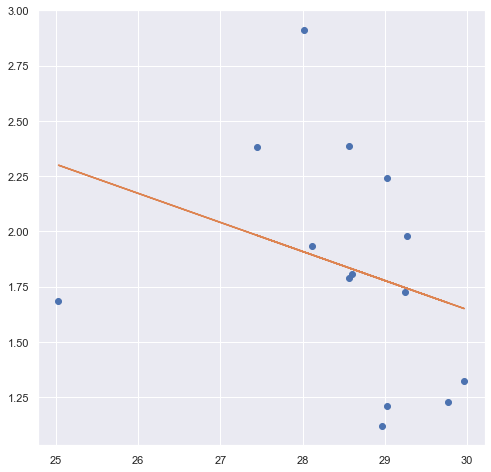

In [128]:
# plot_stazionario_varianza permette di ottenere uno scatterplot della media e della varianza calcolata per ogni anno
# Se Year e' la variabile di input
utils.print_plot(df_train_prep_livello,'Livello_Acqua').plot_stazionario_varianza('Year')

L'asse x rappresenta la media e l'asse y la varianza annuale.
La retta arancione rappresenta stima per la retta di regressione. Non sembra esserci una regressione lineare ben definita a meno che si tolga l'outlier con media minore.

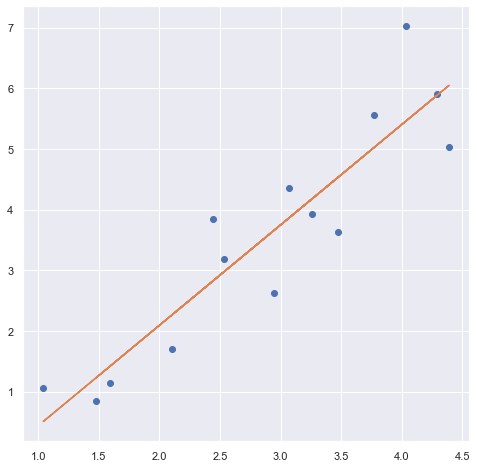

In [129]:
# Analogo per la Portata
utils.print_plot(df_train_prep_portata, 'Portata_Uscita').plot_stazionario_varianza('Year')
# Bella dipendenza crescente lineare

In [130]:
serie_Livello = df_train_prep_livello['Livello_Acqua']
serie_Livello_log = np.log(serie_Livello)

# Definisco la nuova colonna con il logaritmo della serie sia nel dataset con attributi normalizzati sia in quello senza
df_train_prep_livello['Log_Livello_Acqua'] = serie_Livello_log
df_train_livello['Log_Livello_Acqua'] = serie_Livello_log

In [131]:
serie_Portata = df_train_prep_portata['Portata_Uscita']
serie_Portata_log = np.log(serie_Portata)

df_train_prep_portata['Log_Portata_Uscita'] = serie_Portata_log
df_train_portata['Log_Portata_Uscita'] = serie_Portata_log

## Aggiunta colonne utili per ARIMA

In [132]:
# Train livello
# Aggiungo tempo, tempo al quadrato e intercetta al dataset
t = np.array(range(1,len(df_train_prep_livello)+1))
t2 = t**2

df_train_prep_livello.loc[:,'Time'] = t
df_train_prep_livello['Time_square'] = t2
df_train_prep_livello['Intercetta'] = 1

df_train_prep_livello.head()

,Pioggia_Totale,Temperatura_Zona_5,Portata_Uscita,Livello_Acqua,Data,Year,cc_1,cc_2,ss_1,ss_2,Log_Livello_Acqua,Time,Time_square,Intercetta
0,-0.391247,-1.164693,-0.562852,30.49,2004-01-02,2004,0.999852,0.999408,0.017202,0.034398,3.417399,1,1,1
1,-0.391247,-1.460430,-0.562852,30.52,2004-01-03,2004,0.999408,0.997634,0.034398,0.068755,3.418382,2,4,1
2,-0.391247,-1.813872,-0.562852,30.53,2004-01-04,2004,0.998669,0.994678,0.051584,0.103031,3.418710,3,9,1
3,-0.385787,-1.972560,-0.562852,30.55,2004-01-05,2004,0.997634,0.990545,0.068755,0.137185,3.419365,4,16,1
4,-0.391247,-1.777807,-0.562852,30.58,2004-01-06,2004,0.996303,0.985240,0.085906,0.171177,3.420346,5,25,1


In [133]:
# Train portata
# Aggiungo tempo, intercetta e livello al quadrato al dataset
t = np.array(range(1,len(df_train_prep_portata)+1))

df_train_prep_portata['Time'] = np.sin(np.log(t+1))
df_train_prep_portata['Intercetta'] = 1
df_train_prep_portata['Livello_Acqua_square'] = df_train_prep_portata['Livello_Acqua']**2

df_train_prep_portata.head()

,Pioggia_Totale,Temperatura_Zona_5,Livello_Acqua,Portata_Uscita,Data,Year,cc_1,cc_2,ss_1,ss_2,Log_Portata_Uscita,Time,Intercetta,Livello_Acqua_square
0,-0.391247,-1.164693,0.745450,0.5,2004-01-02,2004,0.999852,0.999408,0.017202,0.034398,-0.693147,0.638961,1,0.555696
1,-0.391247,-1.460430,0.776161,0.5,2004-01-03,2004,0.999408,0.997634,0.034398,0.068755,-0.693147,0.890577,1,0.602427
2,-0.391247,-1.813872,0.806873,0.5,2004-01-04,2004,0.998669,0.994678,0.051584,0.103031,-0.693147,0.983028,1,0.651043
3,-0.385787,-1.972560,0.815647,0.5,2004-01-05,2004,0.997634,0.990545,0.068755,0.137185,-0.693147,0.999254,1,0.665280
4,-0.391247,-1.777807,0.837584,0.5,2004-01-06,2004,0.996303,0.985240,0.085906,0.171177,-0.693147,0.975687,1,0.701547


In [134]:
# Test portata
# Aggiungiamo stesse colonne
t = np.array(range(1,len(df_test_prep_portata)+1))

df_test_prep_portata['Time'] = np.sin(np.log(t+1))
df_test_prep_portata['Livello_Acqua_square'] = df_test_prep_portata['Livello_Acqua']**2
